In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

khadiza13_ds_with_three_path = kagglehub.dataset_download('khadiza13/ds-with-three')

print('Data source import complete.')


In [ ]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install -q transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

In [ ]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModel,  AutoConfig
from collections import defaultdict
import torch
from transformers import ViTImageProcessor,ViTModel, ViTConfig
import warnings
warnings.filterwarnings('ignore')
from transformers import get_scheduler
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,IterableDataset,DataLoader
from tqdm.auto import tqdm
from collections import defaultdict
from torch.optim import AdamW
import torchvision
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
from datasets import load_dataset
from torch.cuda import amp
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import gc
gc.enable()

2025-06-20 19:32:23.791528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750447943.980484      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750447944.031466      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [ ]:
df = pd.read_csv("/kaggle/input/ds-with-three/3 class/dataset_with_3class - Sheet1.csv")
df.head()

,image,text,label
0,KAM (100).jpg,পরীক্ষার আগের রাতে বারোটার সময় ঘুমে চোখ বন্ধ হ...,non-misogyny
1,KAM (102).png,আমি ক্যানো সেঞ্চুরি করিনি জানো? তোমরা দেখলেই আ...,non-misogyny
2,KAM (103).png,চ্যাম্পিয়ন এর পর লীগ কেন? কালকে হরতাল!,non-misogyny
3,KAM (104).jpg,দেশের শিক্ষামন্ত্রী যদি দেয় এইরকম পেরা কেমনে ক...,non-misogyny
4,KAM (106).png,টিচার আর নাপিত এর মাঝে অনেক টা মিল রয়েছে দুজন...,non-misogyny


In [ ]:
# Check the shape of the dataset
print("Shape of the dataset:", df.shape)

Shape of the dataset: (3116, 3)


In [ ]:
# Check for null values
print("\nNull values in the dataset:")
print(df.isnull().sum())

# Check for duplicate values
print("\nDuplicate values in the dataset:")
print(df.duplicated().sum())


Null values in the dataset:
image    0
text     0
label    0
dtype: int64

Duplicate values in the dataset:
0


In [ ]:
# Checking class distribution (count of each class)
class_distribution = df['label'].value_counts()
print("\nClass distribution:")
print(class_distribution)

# Display class-wise shape (how many samples for each class)
for class_name in class_distribution.index:
    class_data = df[df['label'] == class_name]
    print(f"\nClass '{class_name}' contains {class_data.shape[0]} samples.")


Class distribution:
label
stereotype & objectification    1596
non-misogyny                     856
violence or abuse                664
Name: count, dtype: int64

Class 'stereotype & objectification' contains 1596 samples.

Class 'non-misogyny' contains 856 samples.

Class 'violence or abuse' contains 664 samples.


In [ ]:
print(df.columns.tolist())


['image', 'text', 'label']


In [ ]:
df.columns = ['image_name', 'Text', 'label']
df.head()

,image_name,Text,label
0,KAM (100).jpg,পরীক্ষার আগের রাতে বারোটার সময় ঘুমে চোখ বন্ধ হ...,non-misogyny
1,KAM (102).png,আমি ক্যানো সেঞ্চুরি করিনি জানো? তোমরা দেখলেই আ...,non-misogyny
2,KAM (103).png,চ্যাম্পিয়ন এর পর লীগ কেন? কালকে হরতাল!,non-misogyny
3,KAM (104).jpg,দেশের শিক্ষামন্ত্রী যদি দেয় এইরকম পেরা কেমনে ক...,non-misogyny
4,KAM (106).png,টিচার আর নাপিত এর মাঝে অনেক টা মিল রয়েছে দুজন...,non-misogyny


In [ ]:
img_folder = '/kaggle/input/ds-with-three/3 class/img'

# List of all images present in folder
available_images = set(os.listdir(img_folder))

# Images referenced in DataFrame
referenced_images = set(df['image_name'].unique())

# Find missing images
missing_images = referenced_images - available_images

# Print missing image filenames with full path
missing_image_paths = [os.path.join(img_folder, img) for img in missing_images]

print("Missing image files:")
for path in missing_image_paths:
    print(path)

Missing image files:


In [ ]:
with pd.option_context('display.max_colwidth', 0):
    display(df.sample(n=5))

,image_name,Text,label
1220,2937.png,"স্বামী এবং স্ত্রী খুব ঝগড়া করছে। এমন সময় স্ত্রী স্বামীকে রেগে-মেগে গিয়ে বলছে\n""তুমি শুধু আমার বাড়ি, আমার টিভি, আমার ফ্রিজ, আমার সন্তান বল কেন???""\nতুমি বলতে পারো না যে, “আমাদের বাড়ি, আমাদের টিভি, আমাদের ফ্রিজ, আমাদের\nসন্তান...""\n\nঠিক তখনই স্বামী কি যেন খুঁজছিল। তাই দেখে স্ত্রী জিজ্ঞাসা করলো- কি খুজছো?\n\nস্বামী তখন আমতা আমতা করে বলল- “ইয়ে মানে আমাদের শেভিং রেজারটা",stereotype & objectification
279,tangaila (299).jpg,এলেংগার মেয়ে আমি এলেংগার নলা ক্যাডার পোলা আমি*,non-misogyny
3014,in 542.jpg,পিসির ফাইল খোলার আশায় অপেক্ষারত বিকাশ রঞ্জন ভট্টাচার্য্য,non-misogyny
1845,3562.jpg,"গ্রাম থেকে শহরে ঘুরতে আসা চাচা ধানমন্ডি, বসুন্ধরা এলাকায় ওড়না ছাড়া মেয়েদের ঘুরাঘুরি করতে\nদেখার পর \n\nকেয়ামতের আলামত শুরু হয়ে গেসে",stereotype & objectification
2098,3815.jpg,"কিছু মাগি আছে ...\nতারা দেয়না ভালোবাসায় সাড়া,\nতাড়া যে চায় কেবল মোটা বাঁড়া",stereotype & objectification


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.sample(10)

,image_name,Text,label
545,2262.jpg,Arrange marriage is scary what if she - \nPay...,1
1048,2765.jpg,লিজেন্ডরা বুঝবে,1
364,2081.jpg,আমার সামনে বলতি সতী\nআড়ালে জাষ্টফ্রেন্ড দিয়ে ভ...,2
1754,3471.jpg,মেয়েরা বমি করলে সুখবর\nআর\nছেলেরা বমি করলে......,1
2465,924.jpg,ছাড় পায়নি জুলাই শহিদের মেয়েও,2
2198,3915.png,আশিক জ্বীন তোমার পথ চেয়ে বসে আছে!\n\nনিজেই ঠেক...,1
2415,874.jpg,রেট কত? \r\nউড়না কই?,2
2582,1050.jpg,Give me outfit ideas! \r\nKafon poro shundor l...,2
968,2685.jpg,বিয়ের আগে দেহ দিলে সমস্যা কি? যাই দেহ দান করে ...,2
1717,3434.jpg,পেটে হালকা চর্বি না থাকলে শাড়িতে খুব একটা মানা...,1


In [ ]:
# checkpoint = "csebuetnlp/banglabert" "sagorsarker/bangla-bert-base" "csebuetnlp/banglabert_large"
class Config:
    NUM_EPOCHS = 10
    BATCH_SIZE = 32
    MODEL_PATH = "csebuetnlp/banglabert"
    Image_Model = "google/vit-base-patch16-224-in21k"
    LR = 2e-5
    DROPOUT = 0.3
    NUM_CLASSES = 3
    SEED = 42
    MAX_LEN = 100
    DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

config  = Config()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

<Axes: ylabel='Count'>

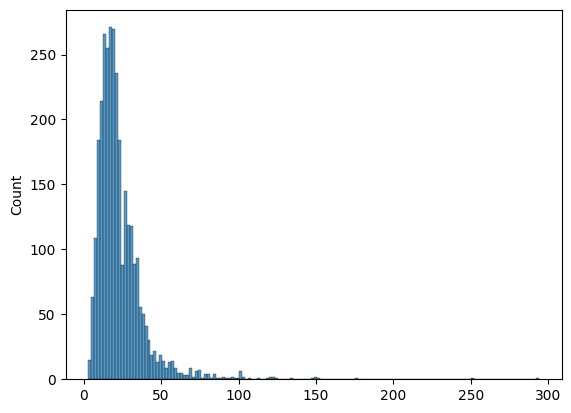

In [ ]:
token_counts = []

for _, row in df.iterrows():
    text = str(row["Text"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

In [ ]:
X = df[['image_name','Text']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, df['label'].values, test_size=0.3, stratify=df['label'].values, random_state=42)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [ ]:
train_df = pd.DataFrame(X_train, columns=['image_name', 'Text'])
train_df['label'] = y_train
val_df = pd.DataFrame(X_val, columns=['image_name', 'Text'])
val_df['label'] = y_val
test_df = pd.DataFrame(X_test, columns = ['image_name', 'Text'])
test_df['label'] = y_test

In [ ]:
train_df['Text'][0]

'পরীক্ষার আগের রাতে বারোটার সময় ঘুমে চোখ বন্ধ হয়ে আসে অন্যান্য রাতে ৩টা বাজলেও চোখ খোলা পুরাই উলালা মুড'

In [ ]:
train_df['image_name'][0]

'KAM (100).jpg'

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, df, tokenizer, processor, is_train=True):
        super(MultimodalDataset, self).__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.processor = processor
        self.label = torch.tensor(df.label.values, dtype=torch.long)
        self.is_train = is_train
        self.max_length = config.MAX_LEN

        # Image transforms
        self.image_mean = processor.image_mean
        self.image_std = processor.image_std
        self.size = processor.size["height"]

        self.train_transforms = Compose([
            RandomResizedCrop(self.size),
            RandomHorizontalFlip(),
            ToTensor(),
            self.normalize_image,
        ])
        self.val_transforms = Compose([
            Resize(self.size),
            CenterCrop(self.size),
            ToTensor(),
            self.normalize_image,
        ])

    def normalize_image(self, image):
        if image.shape[0] == 3:  # RGB image
            return Normalize(mean=self.image_mean, std=self.image_std)(image)
        elif image.shape[0] == 4:  # RGBA image
            # Normalize only the RGB channels
            rgb_image = image[:3]
            normalized_rgb = Normalize(mean=self.image_mean, std=self.image_std)(rgb_image)
            # Add the alpha channel back
            return torch.cat([normalized_rgb, image[3].unsqueeze(0)], dim=0)
        else:
            raise ValueError(f"Unexpected number of channels: {image.shape[0]}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        image_item = f"/kaggle/input/ds-with-three/3 class/img/{df.iloc[index, 0]}"

        text_item = self.df.iloc[index]
        # Process image
        image = Image.open(image_item).convert('RGB')
        if self.is_train:
            image_inputs = self.train_transforms(image)
        else:
            image_inputs = self.val_transforms(image)

        text = str(text_item['Text'])
        text_inputs = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=config.MAX_LEN,
            return_tensors="pt"
        )

        label = self.label[index]
        return{
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0),
            'pixel_values': image_inputs,
            'label': label
        }

In [ ]:
class MultimodalDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.text_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def __call__(self, examples):
        text_inputs = [{k: v for k, v in ex.items() if k not in ['pixel_values', 'label']} for ex in examples]
        image_inputs = [ex['pixel_values'] for ex in examples]
        labels = [ex['label'] for ex in examples]

        batch = self.text_collator(text_inputs)

        batch['pixel_values'] = torch.stack(image_inputs)
        batch['label'] = torch.stack(labels)

        return batch

In [ ]:
processor = ViTImageProcessor.from_pretrained(config.Image_Model)

# Create datasets
train_dataset = MultimodalDataset(train_df, tokenizer, processor, is_train=True)

data_collator = MultimodalDataCollator(tokenizer)

train_loader = DataLoader(train_dataset, batch_size=3, collate_fn=data_collator, num_workers=4)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()
        model_config = AutoConfig.from_pretrained(config.MODEL_PATH)
        self.model = AutoModel.from_pretrained(config.MODEL_PATH,config = model_config)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        last_hidden_state = outputs[0]
        cls_embeddings = last_hidden_state[:, 0]
        return cls_embeddings

In [ ]:
class VisionClassifierModel(nn.Module):
    def __init__(self):
        super(VisionClassifierModel, self).__init__()
        self.model_config = ViTConfig.from_pretrained(config.Image_Model)
        self.model = ViTModel.from_pretrained(config.Image_Model, config=self.model_config)

    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)
        cls_embeddings = outputs.last_hidden_state[:, 0]

        return cls_embeddings

In [ ]:
for batch in train_loader:
    break

In [ ]:
text_model = ClassifierModel()
output = text_model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [ ]:
output.shape

torch.Size([3, 768])

In [ ]:
image_model = VisionClassifierModel()
outputs = image_model(pixel_values=batch['pixel_values'])

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
outputs.shape

torch.Size([3, 768])

In [ ]:
class FusionModel(nn.Module):
    def __init__(self, image_model, classifier_model, num_classes):
        super(FusionModel, self).__init__()
        self.image_model = image_model
        self.classifier_model = classifier_model
        # Adjust the size as necessary
        self.fusion_layer = nn.Sequential(
            nn.Linear(image_model.model_config.hidden_size + classifier_model.model.config.hidden_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, num_classes)
        )

    def forward(self, pixel_values, text_input_ids, text_attention_mask):
        image_output = self.image_model(pixel_values)
        text_features = self.classifier_model(text_input_ids, text_attention_mask)

        combined_features = torch.cat((image_output, text_features), dim=1)
        output = self.fusion_layer(combined_features)
        return output

In [ ]:
image_model = VisionClassifierModel()
classifier_model = ClassifierModel()

In [ ]:
pixel_values = batch['pixel_values']
text_input_ids = batch['input_ids']
text_attention_mask = batch['attention_mask']

In [ ]:
target = batch['label']

In [ ]:
target

tensor([1, 1, 0])

In [ ]:
fusion_model = FusionModel(image_model, classifier_model, num_classes=config.NUM_CLASSES)
output = fusion_model(pixel_values = pixel_values, text_input_ids = text_input_ids, text_attention_mask = text_attention_mask )

In [ ]:
output

tensor([[-0.0576,  0.0711, -0.1208],
        [ 0.0355, -0.0704, -0.0703],
        [ 0.0209, -0.1050, -0.0397]], grad_fn=<AddmmBackward0>)

In [ ]:
pred = torch.argmax(output, dim = -1)
pred

tensor([1, 0, 0])

In [ ]:
y_true = target.detach().numpy()
pred = output.detach().numpy()
y_pred = np.argmax(pred, axis = -1)
f1 = f1_score(y_true, y_pred, average='weighted')
f1

0.6666666666666666

In [ ]:
loss_fct = nn.CrossEntropyLoss()
loss = loss_fct(output,target)
print(loss)

tensor(1.0560, grad_fn=<NllLossBackward0>)


In [ ]:
class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler

    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(pred,target)
        return loss

    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        pred = pred.cpu().numpy()
        y_pred = np.argmax(pred, axis = -1)
        f1 = f1_score(y_true, y_pred, average='weighted')
        return f1

    def train(self, train_dataloader, scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        progress_bar = tqdm(range(num_training_steps), desc="Training")
        for step, data in enumerate(train_dataloader):
            input_ids = data["input_ids"].to(config.DEVICE)
            attention_mask = data["attention_mask"].to(config.DEVICE)
            pixel_inputs = data['pixel_values'].to(config.DEVICE)
            target = data["label"].to(config.DEVICE)
            self.optimizer.zero_grad()
            with amp.autocast():
                pred = self.model(pixel_values = pixel_inputs, text_input_ids = input_ids, text_attention_mask = attention_mask)
                loss = self.loss_fn(target, pred)

            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()

            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
            if step >= num_training_steps:
                break

        return total_training_loss / len(train_dataloader)

    def evaluate(self, eval_dataloader):
        self.model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(config.DEVICE)
                attention_mask = data["attention_mask"].to(config.DEVICE)
                pixel_inputs = data['pixel_values'].to(config.DEVICE)
                target = data["label"].to(config.DEVICE)
                pred = self.model(pixel_values=pixel_inputs, text_input_ids=input_ids, text_attention_mask=attention_mask)
                loss = self.loss_fn(target, pred)
                val_loss += loss.item()
                all_preds.append(pred)
                all_labels.append(target)

        val_loss /= len(eval_dataloader)
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        score = self.compute_metrics(all_labels, all_preds)
        return score, val_loss

In [ ]:
history = defaultdict(list)
def run_training(save_model = False):
    train_dataset = MultimodalDataset(train_df, tokenizer, processor, is_train=True)
    test_dataset = MultimodalDataset(test_df, tokenizer, processor, is_train=False)
    data_collator = MultimodalDataCollator(tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, collate_fn=data_collator, num_workers=4)
    val_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, collate_fn=data_collator, num_workers=4)

    set_random_seed(config.SEED)
    image_model = VisionClassifierModel()
    classifier_model = ClassifierModel()
    model = FusionModel(image_model, classifier_model, num_classes=config.NUM_CLASSES)
    model.to(config.DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr= config.LR, weight_decay=0.01)
    num_training_steps = config.NUM_EPOCHS * len(train_loader)

    scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
    )
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 3
    early_stopping_counter = 0
    best_score = 0.0
    for epoch in range(config.NUM_EPOCHS):
        train_loss = eng.train(train_loader,scaler,num_training_steps)
        val_score,val_loss = eng.evaluate(val_loader)

        print(f" Epoch: {epoch + 1} | Training_loss: {round(train_loss,4)} | Val_loss: {round(val_loss,4)} | Val_f1: {round(val_score,4)}")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        if val_score > best_score:
            best_score = val_score
            early_stopping_counter = 0

            if save_model:
                torch.save(model.state_dict(),f"Multimodal_model.bin")
        else:
            early_stopping_counter +=1

        if early_stopping_counter > early_stopping_iter:
            break

    del model
    gc.collect()

    return round(best_score,5)

In [ ]:
score =run_training(save_model = True)
print(f"Best f1 Score: {score}")

Training:   0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 Epoch: 1 | Training_loss: 1.0121 | Val_loss: 0.9231 | Val_f1: 0.529


Training:   0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 Epoch: 2 | Training_loss: 0.8224 | Val_loss: 0.7532 | Val_f1: 0.6295


Training:   0%|          | 0/690 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc19ad3b9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc19ad3b9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/15 [00:00<?, ?it/s]

 Epoch: 3 | Training_loss: 0.5619 | Val_loss: 0.6946 | Val_f1: 0.7211


Training:   0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 Epoch: 4 | Training_loss: 0.3617 | Val_loss: 0.7638 | Val_f1: 0.7378


Training:   0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 Epoch: 5 | Training_loss: 0.2318 | Val_loss: 0.8437 | Val_f1: 0.7265


Training:   0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 Epoch: 6 | Training_loss: 0.16 | Val_loss: 0.8521 | Val_f1: 0.7413


Training:   0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 Epoch: 7 | Training_loss: 0.118 | Val_loss: 0.8694 | Val_f1: 0.7421


Training:   0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 Epoch: 8 | Training_loss: 0.0929 | Val_loss: 0.9699 | Val_f1: 0.7105


Training:   0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 Epoch: 9 | Training_loss: 0.0696 | Val_loss: 0.9896 | Val_f1: 0.7139


Training:   0%|          | 0/690 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc19ad3b9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7bc19ad3b9c0>^^
^^^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
 ^ ^  ^^^ ^ 

  0%|          | 0/15 [00:00<?, ?it/s]

 Epoch: 10 | Training_loss: 0.0658 | Val_loss: 0.9711 | Val_f1: 0.7163
Best f1 Score: 0.74209


### Evaluation

In [ ]:
model = FusionModel(image_model, classifier_model, num_classes=config.NUM_CLASSES)
model.to(config.DEVICE)

FusionModel(
  (image_model): VisionClassifierModel(
    (model): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTIntermediate(
              (dense): L

In [ ]:
model_path = f"/kaggle/working/Multimodal_model.bin"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test_dataset = MultimodalDataset(test_df, tokenizer, processor, is_train=False)
data_collator = MultimodalDataCollator(tokenizer)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, collate_fn=data_collator, num_workers=4)

In [ ]:
model.eval()
predictions = []
for batch in test_loader:
    batch = {k: v.to(config.DEVICE) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(pixel_values=batch['pixel_values'], text_input_ids=batch['input_ids'], text_attention_mask=batch['attention_mask'])

        # outputs shape is [batch_size, num_classes]
        pred = torch.argmax(outputs, dim=-1)
        predictions.extend(pred.cpu().numpy().tolist())

# Ensure we only keep predictions for actual samples
actual_samples = len(test_loader.dataset)
predictions = predictions[:actual_samples]


In [ ]:
y_true = test_df.label.values
y_pred = predictions

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_true, y_pred))

[[ 94  34   0]
 [ 22 196  21]
 [  8  34  58]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print(f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75       128
           1       0.74      0.82      0.78       239
           2       0.73      0.58      0.65       100

    accuracy                           0.75       467
   macro avg       0.74      0.71      0.72       467
weighted avg       0.74      0.75      0.74       467

[[ 94  34   0]
 [ 22 196  21]
 [  8  34  58]]
0.7420877560385042
0.7451820128479657


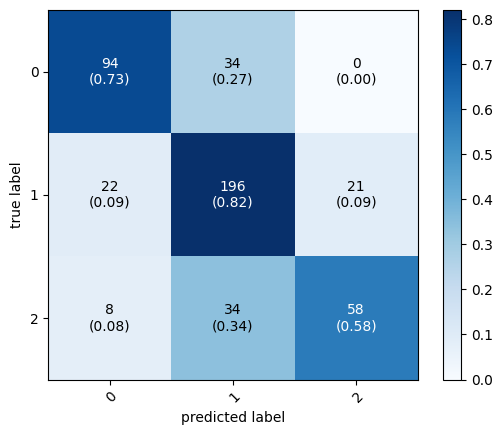

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
y_pred = torch.tensor(y_pred)
y_true = torch.tensor(y_true)

cmat = ConfusionMatrix(task="multiclass", num_classes=3)
confusion_matrix = cmat(y_pred, y_true)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.cpu().numpy(),
                                class_names=[0,1,2],
                                show_normed=True,
                                colorbar=True)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# Show the plot
plt.show()